In [1]:
#Imports

import os, glob, random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D,UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt


In [ ]:
# Basic configuration

IMG_HEIGHT = 128
IMG_WIDTH  = 256
BATCH_SIZE = 2

PERSON_CLASS_ID = 24   


In [3]:
import os, glob

BASE_DIR    = r"C:\Users\Calcu\Asma\Master\CORSI\ComputerVision\Project\Segmentation\dataset\Cityscape Dataset"

# Base directories
LEFTIMG_DIR = r"C:\Users\Calcu\Asma\Master\CORSI\ComputerVision\Project\Segmentation\dataset\Cityscape Dataset\leftImg8bit"
GTFINE_DIR  = r"C:\Users\Calcu\Asma\Master\CORSI\ComputerVision\Project\Segmentation\dataset\Fine Annotations\gtFine"


In [ ]:
def get_image_mask_pairs(split):
    """
    split: 'train' | 'val' | 'test'
    returns list of (image_path, mask_path)
    """
    # image search pattern
    img_glob = os.path.join(LEFTIMG_DIR, split, "*", "*_leftImg8bit.png")
    img_paths = sorted(glob.glob(img_glob))

    pairs = []
    for img_path in img_paths:
        # Example:
        # img:  ...\Cityscape Dataset\leftImg8bit\train\cologne\cologne_000001_000019_leftImg8bit.png
        # mask: ...\Fine Annotations\gtFine\train\cologne\cologne_000001_000019_gtFine_labelIds.png

        city = os.path.basename(os.path.dirname(img_path))  # "cologne"
        filename = os.path.basename(img_path).replace("_leftImg8bit.png",
                                                      "_gtFine_labelIds.png")

        mask_path = os.path.join(GTFINE_DIR, split, city, filename)

        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
        else:
            print("⚠️ Missing mask for:", img_path)
            print("  Expected mask:", mask_path)

    return pairs


train_pairs = get_image_mask_pairs("train")
val_pairs   = get_image_mask_pairs("val")
test_pairs  = get_image_mask_pairs("test")

print("Train pairs:", len(train_pairs))
print("Val pairs:  ", len(val_pairs))
print("Test pairs: ", len(test_pairs))



Train pairs: 2975
Val pairs:   500
Test pairs:  1525


In [5]:
# Dataset building (TF data pipeline)


def load_image_and_mask(img_path, mask_path):
    # Read & decode image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    # Read & decode mask (single channel integer IDs)
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(
        mask, (IMG_HEIGHT, IMG_WIDTH),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    # Cityscapes labelIds: make binary mask (person = 1, else 0)
    # mask values are ints; we compare with PERSON_CLASS_ID
    mask = tf.cast(mask, tf.int32)
    mask = tf.cast(tf.equal(mask, PERSON_CLASS_ID), tf.float32)

    return img, mask

def make_dataset(pairs, shuffle=True):
    img_paths  = [p[0] for p in pairs]
    mask_paths = [p[1] for p in pairs]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda ip, mp: load_image_and_mask(ip, mp),
                num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=512)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_pairs, shuffle=True)
val_ds   = make_dataset(val_pairs, shuffle=False)


In [6]:
#  Build Sequential CNN segmentation model


model = Sequential([
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Encoder
    Conv2D(32, 3, activation="relu", padding="same"),
    Conv2D(32, 3, activation="relu", padding="same"),
    MaxPool2D(),

    Conv2D(64, 3, activation="relu", padding="same"),
    Conv2D(64, 3, activation="relu", padding="same"),
    MaxPool2D(),

    Conv2D(128, 3, activation="relu", padding="same"),
    Conv2D(128, 3, activation="relu", padding="same"),

    # Decoder
    UpSampling2D(),  # back to previous spatial size
    Conv2D(64, 3, activation="relu", padding="same"),
    Conv2D(64, 3, activation="relu", padding="same"),

    UpSampling2D(),
    Conv2D(32, 3, activation="relu", padding="same"),
    Conv2D(32, 3, activation="relu", padding="same"),

    # Final 1-channel mask, values in [0,1]
    Conv2D(1, 1, activation="sigmoid", padding="same")
])

model.summary()


c:\Users\Calcu\Coding\python_codes\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 128, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,473 (1.62 MB)

 Trainable params: 425,473 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile & train


# IoU metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union        = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", iou_metric]
)



early_stop = EarlyStopping(
    monitor="val_iou_metric",  # use IoU, not accuracy
    mode="max",
    patience=5,
    restore_best_weights=True
)

EPOCHS = 20  

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 1883s 1s/step - accuracy: 0.9897 - iou_metric: 0.2249 - loss: 0.0703 - val_accuracy: 0.9887 - val_iou_metric: 0.1980 - val_loss: 0.0595
Epoch 2/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 1458s 964ms/step - accuracy: 0.9906 - iou_metric: 0.2294 - loss: 0.0515 - val_accuracy: 0.9887 - val_iou_metric: 0.1980 - val_loss: 0.0648
Epoch 3/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 537s 356ms/step - accuracy: 0.9909 - iou_metric: 0.2264 - loss: 0.0495 - val_accuracy: 0.9887 - val_iou_metric: 0.1980 - val_loss: 0.0594
Epoch 4/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 714s 474ms/step - accuracy: 0.9908 - iou_metric: 0.2285 - loss: 0.0516 - val_accuracy: 0.9887 - val_iou_metric: 0.1980 - val_loss: 0.0596
Epoch 5/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 329s 217ms/step - accuracy: 0.9906 - iou_metric: 0.2263 - loss: 0.0523 - val_accuracy: 0.9887 - val_iou_metric: 0.1980 - val_loss: 0.0616
Epoch 6/20
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 459s 305ms/step - accuracy: 0.9911 - iou_metric: 0.2228 - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


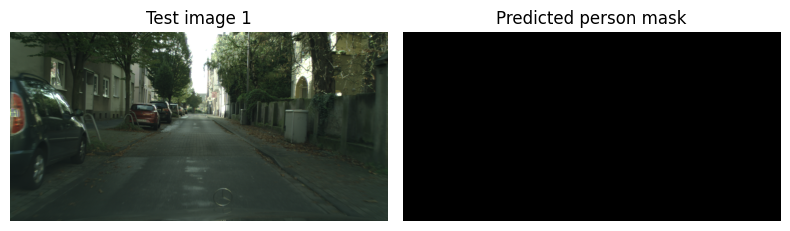

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


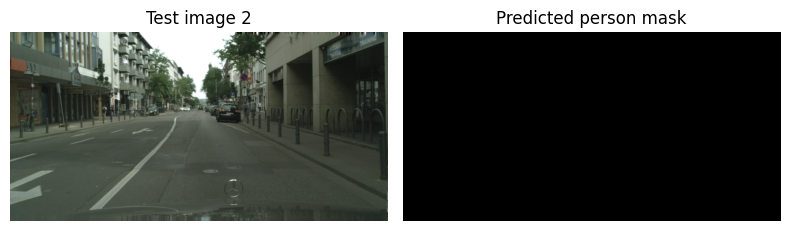

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


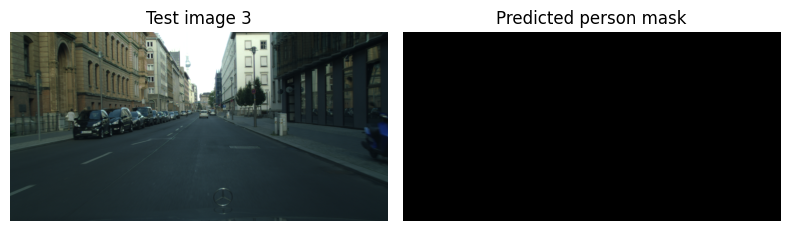

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


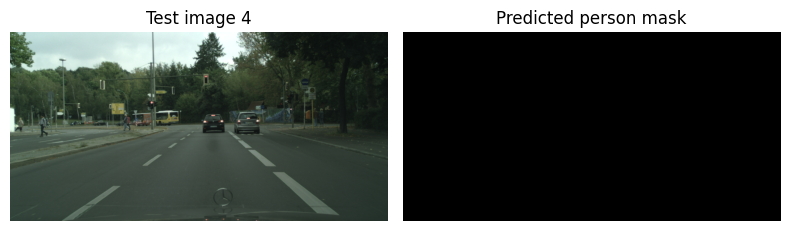

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


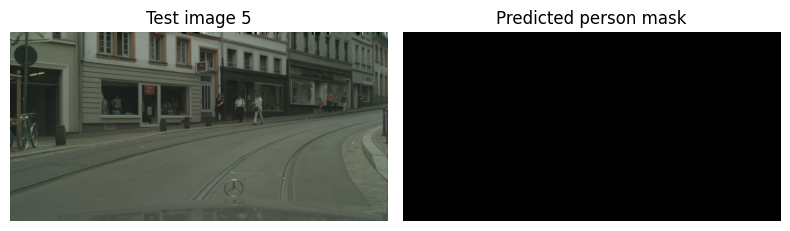

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


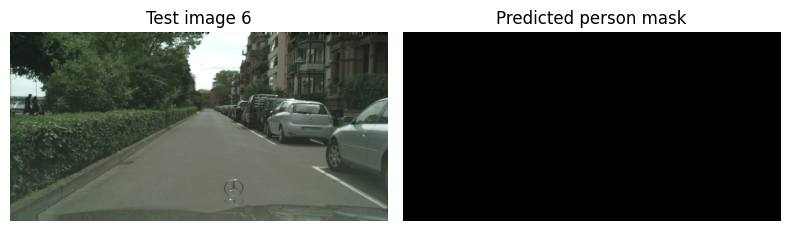

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


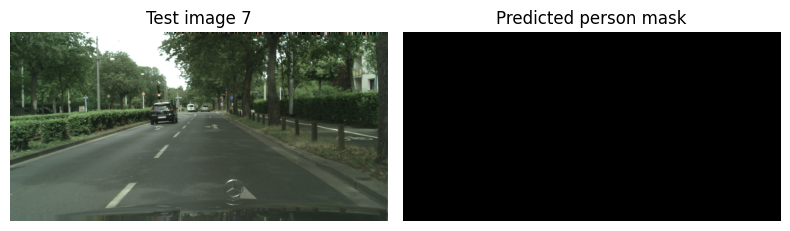

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


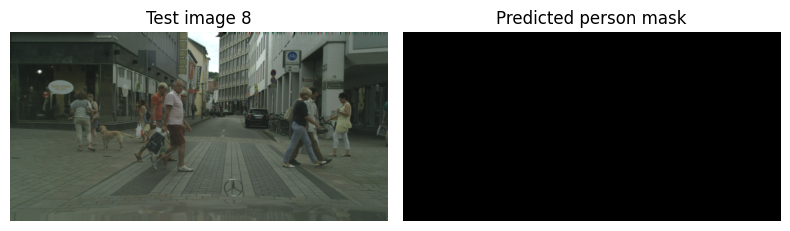

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


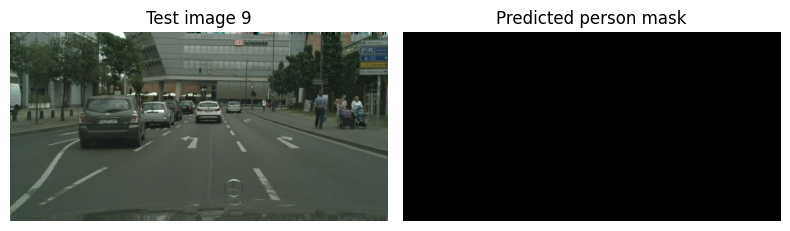

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


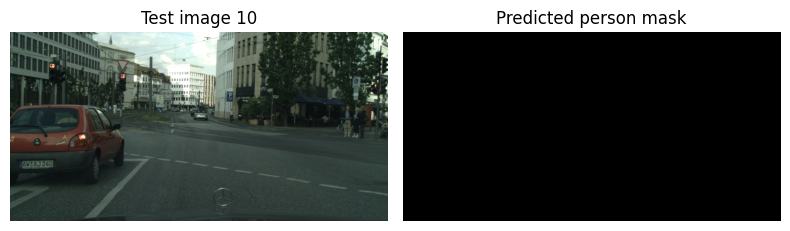

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


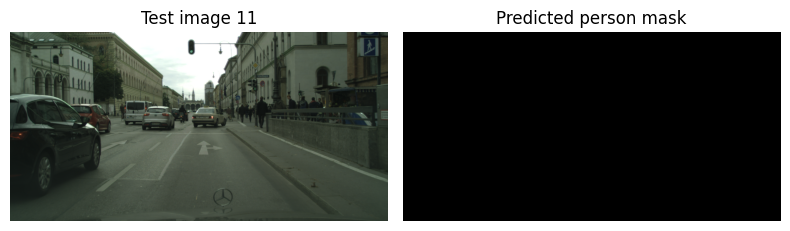

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


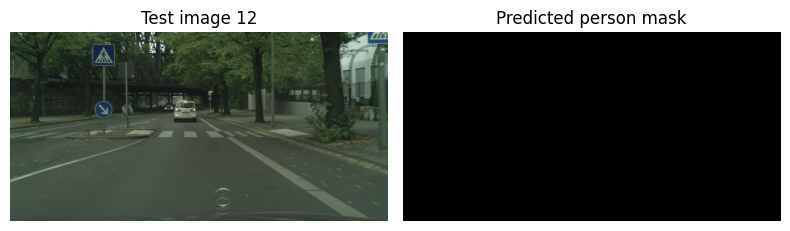

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


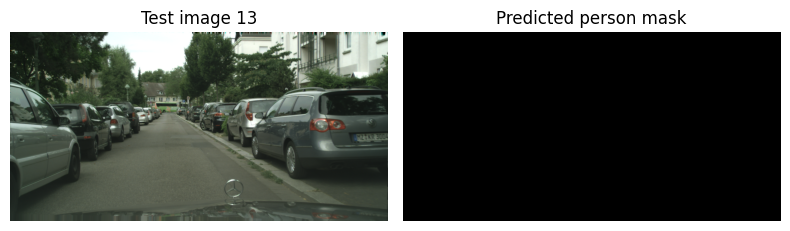

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


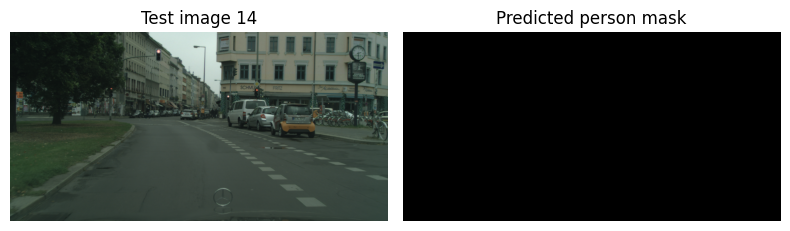

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


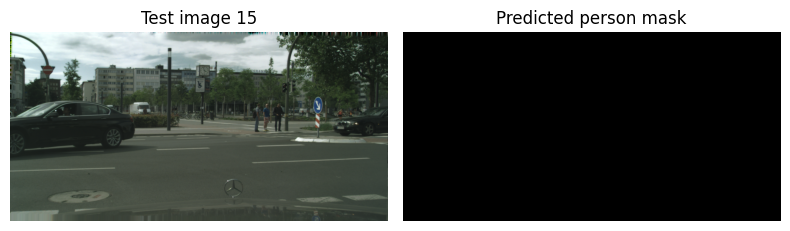

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


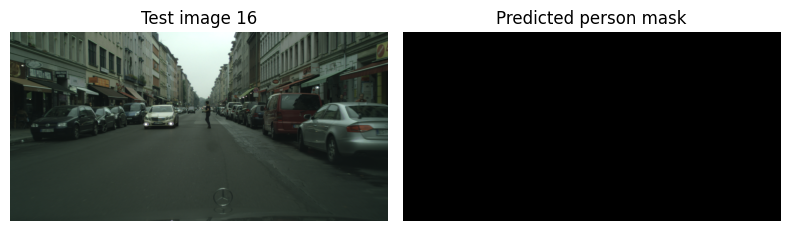

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


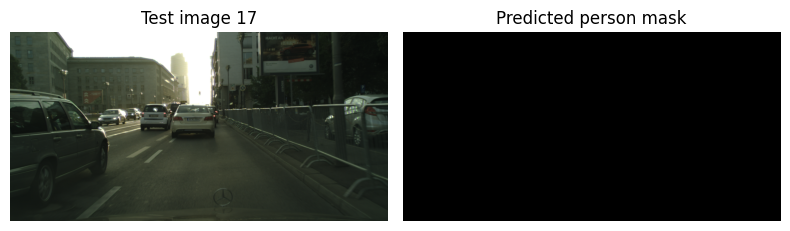

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


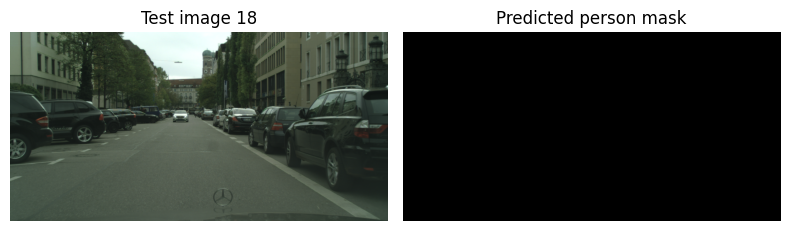

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


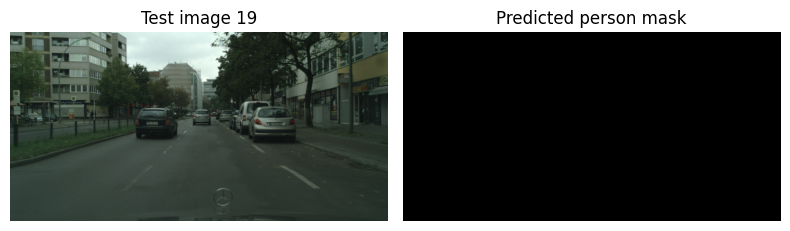

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


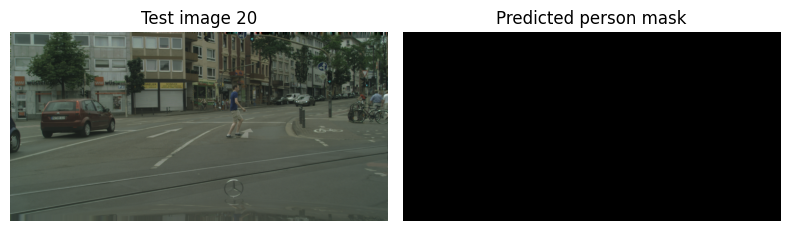

In [10]:
# Test on 10 images from the test set


# take 10 random images from TEST
random.seed(0)
sample_pairs = random.sample(test_pairs, k=20)

def load_image_only(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img_resized = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return img, img_resized  # original size, resized

for i, (img_path, mask_path) in enumerate(sample_pairs):
    orig_img, img_resized = load_image_only(img_path)
    pred = model.predict(tf.expand_dims(img_resized, axis=0))[0]
    pred_mask = (pred > 0.5).astype("float32")

    # Plot original + predicted mask
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.title(f"Test image {i+1}")
    plt.imshow(orig_img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Predicted person mask")
    plt.imshow(pred_mask[:,:,0], cmap="gray")  # white = person, black = background
    plt.axis("off")

    plt.tight_layout()
    plt.show()
